## Jan 18 ##

__Experiment: Cooling Mechanisms and Modelling__

__Group: Logan MacHale and Jaden Majid__

__14:20__ Rods were placed into boiling water.

__15:10__ Rods were removed from boiling water and temperature was observed every minute for 50 minutes or 3000 seconds.

__15:10-16:00__ Data was placed into a csv file for later use in code. Temperature and time were recorded.

__16:20__ Started writing code to display the temperature of the rods over time with uncertainties.

## Data Collection and Uncertainties ##

Data was collected by measing the temperature of the aluminum cylinders every 60s. The temperature measurements for each cylinder were spaced 20s apart during the minute so that each time the temperature was observed could be more precisely measured.

The uncertainty in time was taken to be a gaussian PDF with $\sigma = 1s$ as recording the temperature at exactly the right time was difficult.

The uncertainty in temperature was taken to be a gaussian PDF with $\sigma = 2.5K$ according to manufacturer specifications.

## Experimental Question/Objective ##

__How well do the differential equations described in the convective and radiative cooling theory describe the cooling process of the 3 aluminum rods used in the experiment?__

This will be tested by collecting experimental data on the cooling of the rods as temperature over time. This data will be compared to a simulation of the cooling process for each of the three aluminum rods to attempt to answer this question.

__Hypothesis:__ The simulation produced by the differential equations described prior will be similar to the experimental data in that the graph of temperature over time will have the same general shape and the rate at which rods cooled relative to each other should be similar to the experimental data.

## Jan 25 ##

__Activity Log__

__14:10__ Rod dimensions were re-measured

__14:30__ Simulation coding was finished, started coding chi-squared comparison

__15:00__ Chi-squared comparison of theoretical simulation and data complete

__15:10__ Started coding emessivity fit


__Chi squared tool__

The chi squared comparinson tool acts as a quantifer for "goodness of fit". A higher chi squared means a worse fit while a lower one means a better fit.

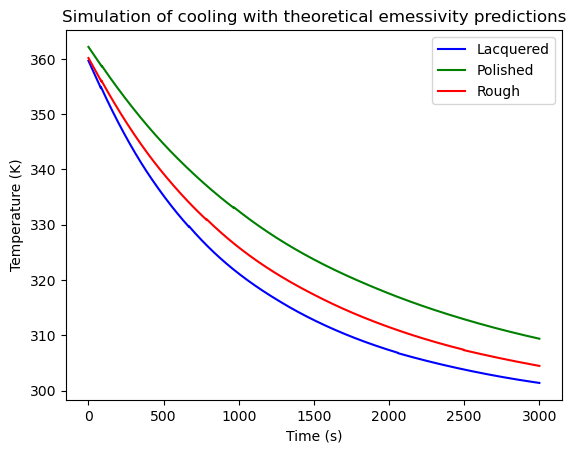

In [1]:
import numpy as np
from scipy import integrate
import matplotlib.pyplot as plt

sigma = 5.670374419E-8

emmL = 0.7
emmP = 0.03
emmR = 0.4

rhoAl = 2710
hcAl = 897
Tamb = 22.2 + 273.15

radL = 12.55E-3
radP = 12.95E-3
radR = 12.95E-3

lengthL = 282E-3
lengthP = 305E-3
lengthR = 304.5E-3

hlengthL = 82.1E-3
hlengthP = 80.1E-3
hlengthR = 80.5E-3

hrad = 3.4E-3

volL = np.pi * radL ** 2 * lengthL - np.pi * hrad ** 2 * hlengthL
volP = np.pi * radP ** 2 * lengthP - np.pi * hrad ** 2 * hlengthR
volR = np.pi * radR ** 2 * lengthR - np.pi * hrad ** 2 * hlengthR

holeA = 3.5E-3 ** 2 * np.pi

saL = 2 * radL * np.pi * lengthL - holeA + radL ** 2 * np.pi
saP = 2 * radP * np.pi * lengthP - holeA + radP ** 2 * np.pi
saR = 2 * radR * np.pi * lengthR - holeA + radR ** 2 * np.pi

massL = rhoAl * volL
massP = rhoAl * volP
massR = rhoAl * volR

TiL = 359.65
TiP = 362.15
TiR = 360.15

y_0L = [TiL]
carrL = [massL, emmL, saL, radL]
y_0P = [TiP]
carrP = [massP, emmP, saP, radP]
y_0R = [TiR]
carrR = [massR, emmR, saR, radR]

y_0arr = [y_0L, y_0P, y_0R]
carrAll = [carrL, carrP, carrR]


def h(T, T_0, r):
    return ((T - T_0) / (2 * r)) ** (1/4)


def dydt_arr(t, y_arr, M, e, A, r):
    """Relates the used physical quantities to their differential
    equations for use in the scipy numerical integration function"""

    T = y_arr[0]

    # dT/dt
    return np.array([(-A * e * sigma * T ** 4 - 1.32 * h(T, Tamb, r) * A * (T - Tamb) + A * e * sigma * Tamb ** 4) / (M * hcAl)])


t_0 = 0
t_f = 3000
steps = int(1E5)
t_arr = np.linspace(t_0, t_f, steps)

solarr = []

for i in range(3):
    sol = integrate.solve_ivp(dydt_arr, (t_0, t_f),
                              y_0arr[i],
                              method='LSODA',
                              t_eval=t_arr,
                              args=carrAll[i])

    solT = sol['y'][0]
    solarr.append(solT)

plt.title("Simulation of cooling with theoretical emessivity predictions")
plt.xlabel("Time (s)")
plt.ylabel("Temperature (K)")
plt.plot(t_arr, solarr[0], "b")
plt.plot(t_arr, solarr[1], "g")
plt.plot(t_arr, solarr[2], "r")
plt.legend(['Lacquered', 'Polished', 'Rough'])
plt.show()

Lacquered Chi-Square:  3.4850689498562675
Polished Chi-Square:  4.506764870773296
Rough Chi-Square:  3.6740880318098124


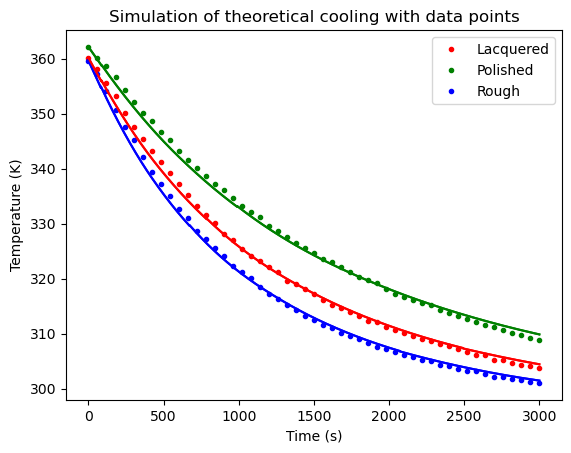

In [5]:
fname = 'experimentdata.csv'
colours = ["r.", "g.", "b."]

data = np.loadtxt(fname, delimiter=',', comments='#',
                  usecols=(0, 4, 5, 6))

x = data[:, 0]
plt.plot(x, data[:, 1], colours[0], x, data[:, 2],
         colours[1], x, data[:, 3], colours[2])

plt.plot(t_arr, solarr[0], "b")
plt.plot(t_arr, solarr[1], "g")
plt.plot(t_arr, solarr[2], "r")


# %%
t_0 = 0
t_f = 3000
steps = int(t_f*1E2)
t_arr = np.linspace(t_0, t_f, steps)

steps_per_data = int(3*20 * steps / t_f)


def chi_square(data, model, sigma=2.5):
    return np.sum((model-data)**2/sigma**2)


solarr = []


def model_function(i):
    sol = integrate.solve_ivp(dydt_arr, (t_0, t_f),
                              y_0arr[i],
                              method='LSODA',
                              t_eval=t_arr,
                              args=carrAll[i])

    solT = sol['y'][0]
    solarr.append(solT)


fname = 'experimentdata.csv'

data = np.loadtxt(fname, delimiter=',', comments='#',
                  usecols=(0, 4, 5, 6))

for i in range(3):
    model_function(i)


print("Lacquered Chi-Square: ",
      chi_square(data[:-1, 3], solarr[0][::steps_per_data]))
print("Polished Chi-Square: ",
      chi_square(data[:-1, 2], solarr[1][::steps_per_data]))
print("Rough Chi-Square: ",
      chi_square(data[:-1, 1], solarr[2][::steps_per_data]))


plt.title("Simulation of theoretical cooling with data points")
plt.xlabel("Time (s)")
plt.ylabel("Temperature (K)")
plt.plot(t_arr, solarr[0], "b")
plt.plot(t_arr, solarr[1], "g")
plt.plot(t_arr, solarr[2], "r")
plt.legend(['Lacquered', 'Polished', 'Rough'])
plt.show()

# Feb 1 #

__Activity Log__

__15:00__ Emessivity fitting code complete


In [3]:
count = 0
i = 0

names = ["Lacquered", "Polished", "Rough"]
carrL = [massL, emmL, saL, radL]
carrP = [massP, emmP, saP, radP]
carrR = [massR, emmR, saR, radR]

carrAll = [carrL, carrP, carrR]
emissivities = []
chis = []


def get_chi(e):
    # global i

    carrAll[i][1] = e

    sol = integrate.solve_ivp(dydt_arr, (t_0, t_f),
                              y_0arr[i],
                              method='LSODA',
                              t_eval=t_arr,
                              args=carrAll[i])

    solT = sol['y'][0]

    return chi_square(data[:-1, 3-i], solT[::steps_per_data])


num_emissivities = 5


def find_e(e_range=np.linspace(1E-9, 1, num_emissivities)):
    global count

    chis = list(map(get_chi, e_range))
    minarg = np.argmin(chis)
    minchi = min(chis)
    # print("Count: ", count)
    # print("minchi: ", minchi)
    # print("minarg: ", minarg)
    # if i == 1:
    #     print("minchi: ", minchi)
    #     print("min e: ", e_range[minarg])
    #     print(e_range)

    if minchi < 1 or count > 20:
        return e_range[minarg], minchi

    count += 1

    if minarg == num_emissivities-1:

        return find_e(np.linspace(e_range[minarg-1], e_range[minarg]+(max(e_range)-min(e_range))/num_emissivities, num_emissivities))

    if minarg == 0:
        min_e = e_range[minarg]-(max(e_range)+min(e_range))/num_emissivities
        if min_e < 0:
            min_e = 1E-7

        return find_e(np.linspace(min_e, e_range[minarg+1], num_emissivities))

    return find_e(np.linspace(e_range[minarg-1], e_range[minarg+1], num_emissivities))


for x in range(3):
    count = 0
    i = x
    results = find_e()
    emissivities.append(results[0])
    chis.append(results[1])
    print(names[i])
    print("emissivity found:", results[0])
    print("chi-square:", results[1])
    print()

Lacquered
emissivity found: 0.687528729751253
chi-square: 3.4850689498562675

Polished
emissivity found: 5.984609191380338e-08
chi-square: 4.506764870773296

Rough
emissivity found: 0.4028204685460931
chi-square: 3.6740880318098124



[0.4275476052805369, 5.984609191380338e-08, 0.025305379599014733, 0.01295]
Lacquered Chi-Square:  3.4850689498562675
Polished Chi-Square:  4.506764870773296
Rough Chi-Square:  3.6740880318098124


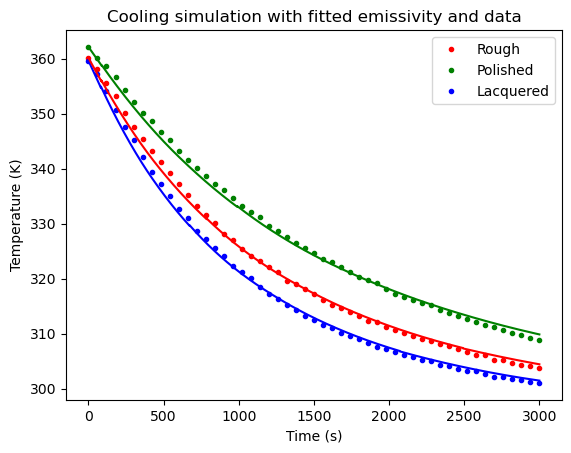

In [6]:
carrAll[0][1] = emissivities[0]
carrAll[1][1] = emissivities[1]
carrAll[2][1] = emissivities[2]
print(carrAll[:][1])

solarr = []

for i in range(3):
    sol = integrate.solve_ivp(dydt_arr, (t_0, t_f),
                              y_0arr[i],
                              method='LSODA',
                              t_eval=t_arr,
                              args=carrAll[i])

    solT = sol['y'][0]
    solarr.append(solT)


print("Lacquered Chi-Square: ",
      chis[0])
print("Polished Chi-Square: ",
      chis[1])
print("Rough Chi-Square: ",
      chis[2])

x = data[:, 0]
plt.plot(x, data[:, 1], colours[0], x, data[:, 2],
         colours[1], x, data[:, 3], colours[2])

plt.title("Cooling simulation with fitted emissivity and data")
plt.xlabel("Time (s)")
plt.ylabel("Temperature (K)")
plt.plot(t_arr, solarr[0], "b")
plt.plot(t_arr, solarr[1], "g")
plt.plot(t_arr, solarr[2], "r")
plt.legend(['Rough', 'Polished', 'Lacquered'])
plt.show()